In [1]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models



    

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
images_path = Path('Data/images')
anno_path = Path('Data/annotations')

In [4]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [5]:
df_train = generate_train_df(anno_path)


In [6]:
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [7]:
print(df_train.shape)
df_train.head()

(877, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,Data/images/road669.png,300,400,2,56,319,65,330
1,Data/images/road498.png,300,400,0,86,130,118,171
2,Data/images/road31.png,400,300,3,213,128,243,196
3,Data/images/road622.png,300,400,0,68,92,100,125
4,Data/images/road44.png,268,400,3,95,50,115,95


In [8]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [9]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

In [10]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [11]:
new_paths = []
new_bbs = []
train_path_resized = Path('./Data/image_resized/')
for index, row in df_train.iterrows():
    new_path, new_bb = resize_image_bb(row['filename'], train_path_resized,create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs



In [12]:
im = cv2.imread(str(df_train.values[55][0]))
bb = create_bb_array(df_train.values[55])
print(im.shape)

(400, 300, 3)


In [13]:
Y = create_mask(bb,im)
mask_to_bb(Y)

array([131.,  78., 179., 127.], dtype=float32)

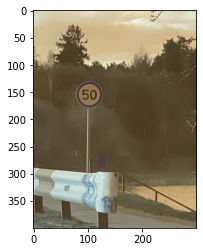

In [14]:
plt.imshow(im)

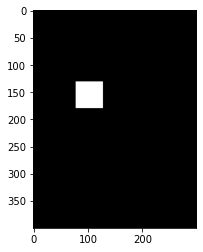

In [15]:
plt.imshow(Y,cmap='gray')

In [16]:
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)



In [17]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [18]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

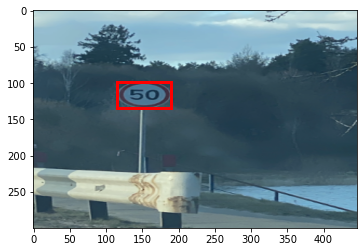

In [19]:
im = cv2.imread(str(df_train.values[55][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[55][9])

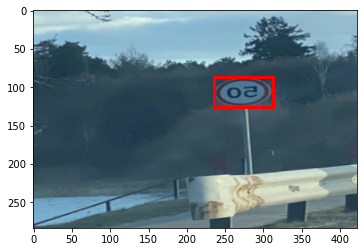

In [20]:
im , bb = transformsXY(str(df_train.values[55][8]),df_train.values[55][9],True)
show_corner_bb(im,bb)

In [21]:
df_train = df_train.reset_index()

In [22]:
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
y_train

357    0
870    0
772    0
855    0
429    0
      ..
106    0
270    0
860    0
435    0
102    3
Name: class, Length: 701, dtype: int64

In [24]:
def normalize(im):
    imagenet_stats = np.array([[0.485,0.456,0.406],[0.229,0.224,0.225]])
    return (im-imagenet_stats[0])/imagenet_stats[1]

In [25]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [44]:
train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)

357    0
870    0
772    0
855    0
429    0
      ..
106    0
270    0
860    0
435    0
102    3
Name: class, Length: 701, dtype: int64


In [27]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [28]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [29]:
def update_optimizer(optimizer,lr):
    for i , param_group in enumerate(optimizer.param_groups):
        param_group["lr"]=lr

In [30]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total

In [31]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [32]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters , lr =0.006)

In [33]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=15)


train_loss 2.315 val_loss 143.216 val_acc 0.250
train_loss 1.552 val_loss 5.877 val_acc 0.653
train_loss 1.184 val_loss 1.177 val_acc 0.744
train_loss 0.944 val_loss 1.185 val_acc 0.722
train_loss 0.933 val_loss 1.132 val_acc 0.699
train_loss 1.082 val_loss 6.404 val_acc 0.733
train_loss 1.035 val_loss 0.984 val_acc 0.744
train_loss 1.094 val_loss 4.691 val_acc 0.597
train_loss 0.977 val_loss 1.018 val_acc 0.750
train_loss 0.968 val_loss 1.027 val_acc 0.716
train_loss 0.923 val_loss 0.918 val_acc 0.739
train_loss 0.857 val_loss 1.201 val_acc 0.619
train_loss 0.897 val_loss 0.931 val_acc 0.739
train_loss 0.845 val_loss 1.336 val_acc 0.739
train_loss 0.962 val_loss 1.058 val_acc 0.722


0.9616439781243383

In [34]:
update_optimizer(optimizer, 0.001)
train_epocs(model, optimizer, train_dl, valid_dl, epochs=10)

train_loss 0.864 val_loss 0.964 val_acc 0.739
train_loss 0.770 val_loss 0.981 val_acc 0.722
train_loss 0.732 val_loss 0.924 val_acc 0.750
train_loss 0.747 val_loss 0.938 val_acc 0.744
train_loss 0.736 val_loss 1.068 val_acc 0.716
train_loss 0.729 val_loss 1.055 val_acc 0.739
train_loss 0.728 val_loss 1.046 val_acc 0.727
train_loss 0.713 val_loss 1.051 val_acc 0.727
train_loss 0.709 val_loss 1.195 val_acc 0.733
train_loss 0.767 val_loss 0.967 val_acc 0.716


0.7670841380294822

In [35]:
X_val

,new_path,new_bb
710,Data/image_resized/road446.png,"[82.0, 184.0, 134.0, 283.0]"
734,Data/image_resized/road580.png,"[115.0, 259.0, 143.0, 317.0]"
244,Data/image_resized/road129.png,"[85.0, 123.0, 192.0, 235.0]"
231,Data/image_resized/road574.png,"[151.0, 127.0, 245.0, 307.0]"
291,Data/image_resized/road539.png,"[192.0, 244.0, 218.0, 298.0]"
...,...,...
500,Data/image_resized/road442.png,"[103.0, 135.0, 123.0, 177.0]"
215,Data/image_resized/road581.png,"[87.0, 150.0, 120.0, 214.0]"
350,Data/image_resized/road770.png,"[123.0, 205.0, 145.0, 255.0]"
81,Data/image_resized/road821.png,"[79.0, 160.0, 114.0, 232.0]"


In [36]:
im = read_image('./Data/image_resized/road789.png')
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite('./Data/image_test/road789.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [37]:
test_ds = RoadDataset(pd.DataFrame([{'path':'./Data/image_test/road789.jpg'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

In [38]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 423])

In [39]:
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[ 3.2359, -1.3995, -1.1021, -2.6269]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[115.2399, 171.9924, 152.3788, 246.8082]], device='cuda:0',
        grad_fn=<AddmmBackward>))

In [40]:
torch.max(out_class, 1)

torch.return_types.max(
values=tensor([3.2359], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0], device='cuda:0'))

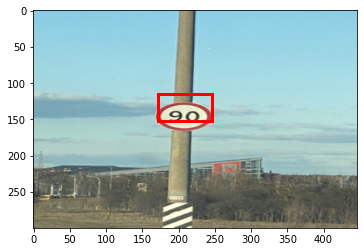

In [41]:
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])